In [1]:
from collections import defaultdict
import csv
import cvxpy as cp
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

from patrolling.agents import *
from patrolling.experiment_utils import *
from patrolling.graph import *
from patrolling.simulation import *
from patrolling.solvers import *
from patrolling.utility import *
from patrolling.visualize import *

# Polymatrix vs. minimax strategies
In this experiment, we test compare the performance of defender strategies obtained using the polymatrix solver and strategies obtained when each defender plays a minimax game independently against the intruder, while the intruder plays its polymatrix solver strategy (strategy obtained by playing the game against all the defenders at once). In this experiment, we want to show that the value obtained by the patroller team is greater when each patroller considers the existence of other patroller robots.

## An observation about "solving" with minimax strategies
It occurs to me that the authors in that paper were not suggesting that everyone playing their minimax strategies actually is a way of finding an equilibrium solution to the game. I now believe that they were simply saying that it would make intuitive sense as a prediction for the game's outcome.

# Questions to answer
1. What are the theoretical values of each solution?
2. Do the solutions obtain the value prescribed by the theoretical model in simulation?

In [2]:
G = generate_random_grid_with_holes(10, 10, p=0.3)
G1 = generate_random_grid_with_holes(8, 8, p=0.3, seed=42)

In [3]:
p_types = [AgentType.GROUND, AgentType.GROUND, AgentType.QUAD]

In [4]:
vis_graphs = {AgentType.QUAD: generate_gridworld_vis_graph(G, 3),
                AgentType.GROUND: generate_gridworld_vis_graph(G, 1)}
occ_utils = {AgentType.QUAD: dict([(v, 1) for v in G.nodes]),
             AgentType.GROUND: dict((v, 1.0) for v in G.nodes)}
reward_struct = {AgentType.QUAD: {'detects': 1, 'is_detected': 1},
                 AgentType.GROUND: {'detects': 1, 'is_detected': 1}}
util_fun = PvIUtilFun(vis_graphs, occ_utils, reward_struct)
U_star = construct_star_top_util_mat(G, p_types, util_fun)

## Solve the game with the different approaches

In [179]:
x_list_poly, y_list, p = compute_ne_star_top(U_star, G, verbose=False, max_iters=20)

In [180]:
x_list_minimax, _, _ = compute_minimax_strategies(U_star, G)

In [181]:
x_list_rand = [np.ones(G.number_of_edges()) / G.number_of_edges() for _ in p_types]

## Compute the best intruder responses for each patroller solution

In [182]:
y_list_opt_poly, p_opt_poly = optimize_intruder_response(U_star, x_list_poly, G)
y_list_opt_minimax, p_opt_minimax = optimize_intruder_response(U_star, x_list_minimax, G)
y_list_opt_rand, p_opt_rand = optimize_intruder_response(U_star, x_list_rand, G)

## Visualize the strategies for each approach

### Polymatrix

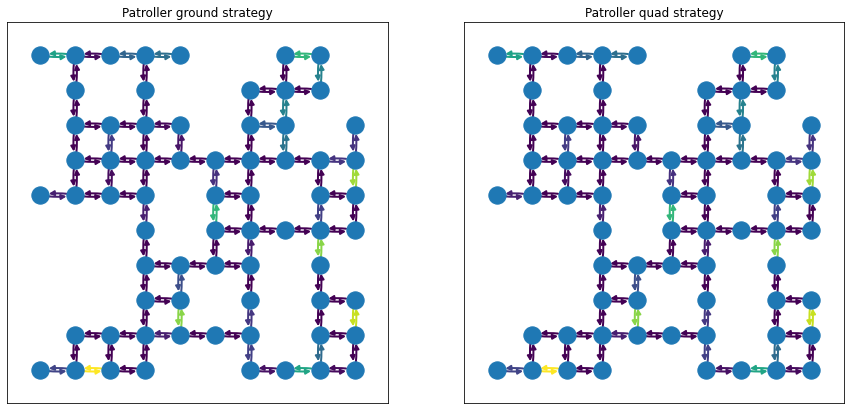

In [189]:
visualize_graphs(G, x_list_poly[:2], 1, 2, ax_titles=['Patroller ground strategy', 'Patroller quad strategy'],
                 colorbar=False, figsize=(15, 7))
fig.savefig('visualizations/pat-strategies-poly-ggq.png', bbox_inches='tight')

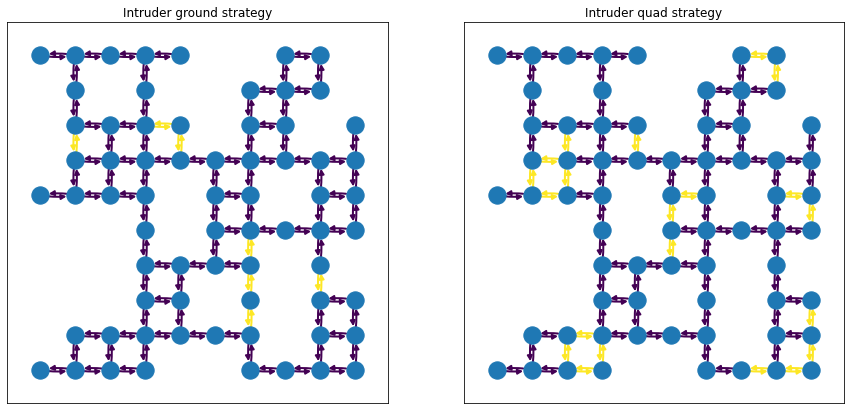

In [190]:
visualize_graphs(G, y_list_opt_poly, 1, 2, ax_titles=['Intruder ground strategy', 'Intruder quad strategy'],
                 colorbar=False, figsize=(15, 7))
fig.savefig('visualizations/int-strategies-poly-ggq.png', bbox_inches='tight')

### Minimax

### Random

## Theoretical utilities
Here we examine the expected utility given by the theoretical model for each patrolling solution. We compare the expected utility before and after the intruder has a chance to improve upon their strategy given that the patroller strategy may not be an equilibrium strategy. Observe that for the polymatrix strategies, the before and after optimization utilities are closer together than the other solutions. In other words, in the minimax and random solutions, the patrollers have left more utility *on the table* by not playing an equilibrium strategy. 

One question: Why can the intruder improve their strategy at all in the polymatrix case. I think this has something to do with the movement constraints and not finding an exact equilibrium.

Another question: Why are the expected payoffs for the minimax and random cases exactly the same?

### Polymatrix solutions

In [164]:
poly_pre_opt_util = compute_star_top_util(x_list_poly, U_star, y_list, p)
poly_post_opt_util = compute_star_top_util(x_list_poly, U_star, y_list_opt_poly, p_opt_poly)
poly_util_gap = -(poly_post_opt_util - poly_pre_opt_util)
print('Before optimization:', poly_pre_opt_util)
print('After optimization:', poly_post_opt_util)

Before optimization: -2.770809052633867
After optimization: -2.803037701110889


### Minimax solutions

In [165]:
minimax_pre_opt_util = compute_star_top_util(x_list_minimax, U_star, y_list, p)
minimax_post_opt_util = compute_star_top_util(x_list_minimax, U_star, y_list_opt_minimax, p_opt_minimax)
minimax_util_gap = -(minimax_post_opt_util - minimax_pre_opt_util)
print('Before optimization:', minimax_pre_opt_util)
print('After optimization:', minimax_post_opt_util)

Before optimization: -2.8218362558166303
After optimization: -2.9282271191662703


In [166]:
rand_pre_opt_util = compute_star_top_util(x_list_minimax, U_star, y_list, p)
rand_post_opt_util = compute_star_top_util(x_list_minimax, U_star, y_list_opt_rand, p_opt_rand)
rand_util_gap = -(rand_post_opt_util - rand_pre_opt_util)
print('Before optimization:', rand_pre_opt_util)
print('After optimization:', rand_post_opt_util)

Before optimization: -2.8218362558166303
After optimization: -2.9282271191662708


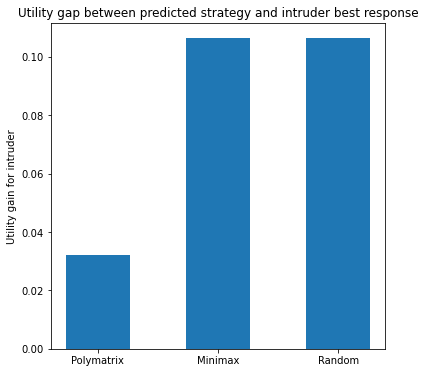

In [167]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_bar_chart([poly_util_gap, minimax_util_gap, rand_util_gap], ax, bar_padding=1,
               ylabel='Utility gain for intruder', title='Utility gap between predicted strategy and intruder best response',
               bar_labels=['Polymatrix', 'Minimax', 'Random'])
fig.savefig('visualizations/util-gap-gqq.png', bbox_inches='tight')

## Do the simulations

In [119]:
poly_simulations = simulate_star_top_patrolling(x_list_poly, y_list_opt_poly, G, vis_graphs, p_types,
                                                p_opt_poly, 0.3, 1000, 20)

In [121]:
minimax_simulations = simulate_star_top_patrolling(x_list_minimax, y_list_opt_minimax, G, vis_graphs, p_types,
                                                   p_opt_minimax, 0.3, 1000, 20)

In [122]:
rand_simulations = simulate_star_top_patrolling(x_list_rand, y_list_opt_rand, G, vis_graphs, p_types,
                                                p_opt_rand, 0.3, 1000, 20)

In [42]:
poly_int_det_rate, poly_pat_det_rate, poly_time_to_det = compute_stats(poly_simulations)
minimax_int_det_rate, minimax_pat_det_rate, minimax_time_to_det = compute_stats(minimax_simulations)
rand_int_det_rate, rand_pat_det_rate, rand_time_to_det = compute_stats(rand_simulations)

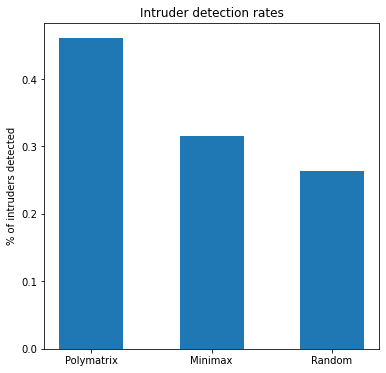

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_bar_chart([poly_int_det_rate, minimax_int_det_rate, rand_int_det_rate], ax, bar_padding=1,
               ylabel='% of intruders detected', title='Intruder detection rates',
               bar_labels=['Polymatrix', 'Minimax', 'Random'])
# fig.savefig('visualizations/int-det-rates-gqq.png', bbox_inches='tight')

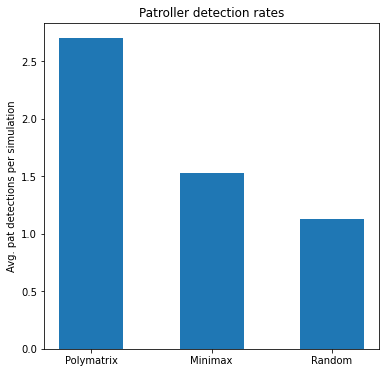

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_bar_chart([poly_pat_det_rate, minimax_pat_det_rate, rand_pat_det_rate], ax, bar_padding=1,
                ylabel='Avg. pat detections per simulation', title='Patroller detection rates',
                bar_labels=['Polymatrix', 'Minimax', 'Random'])
# fig.savefig('visualizations/pat-det-rates-gqq.png', bbox_inches='tight')

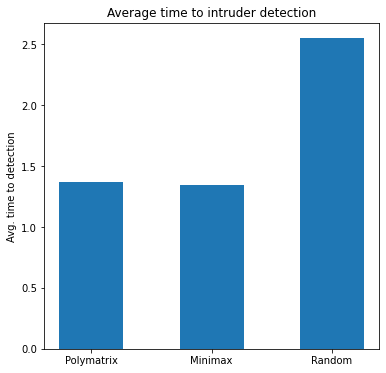

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_bar_chart([poly_time_to_det, minimax_time_to_det, rand_time_to_det], ax, bar_padding=1,
                ylabel='Avg. time to detection', title='Average time to intruder detection',
                bar_labels=['Polymatrix', 'Minimax', 'Random'])
# fig.savefig('visualizations/det-time-gqq.png', bbox_inches='tight')

In [46]:
len(poly_simulations)

10000

# Benchmark on many random graphs

In [24]:
ggq = [AgentType.GROUND, AgentType.GROUND, AgentType.QUAD]
gqq = [AgentType.GROUND, AgentType.QUAD, AgentType.QUAD]

In [25]:
graphs = []
with open('assets/random_graph_parameters.csv', 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    for row in csv_reader:
        m = int(row[0])
        n = int(row[1])
        p = float(row[2])
        seed = int(row[3])
        graphs.append(generate_random_grid_with_holes(m, n, p, seed))

In [26]:
poly_simulations_ggq, minimax_simulations_ggq, rand_simulations_ggq = run_benchmarks(graphs, 
                                                                                     gqq,
                                                                                     n_sim=1000,
                                                                                     T=20)

Benchmarking graph 1/100...


KeyboardInterrupt: 

In [7]:
poly_simulations_gqq, minimax_simulations_gqq, rand_simulations_gqq = run_benchmarks(graphs, 
                                                                                     gqq,
                                                                                     n_sim=10000,
                                                                                     T=20)

Benchmarking graph 1/100...
Benchmarking graph 2/100...
Benchmarking graph 3/100...
Benchmarking graph 4/100...
Benchmarking graph 5/100...
Benchmarking graph 6/100...
Benchmarking graph 7/100...
Benchmarking graph 8/100...
Benchmarking graph 9/100...
Benchmarking graph 10/100...
Benchmarking graph 11/100...
Benchmarking graph 12/100...
Benchmarking graph 13/100...
Benchmarking graph 14/100...
Benchmarking graph 15/100...
Benchmarking graph 16/100...
Benchmarking graph 17/100...
Benchmarking graph 18/100...
Benchmarking graph 19/100...
Benchmarking graph 20/100...
Benchmarking graph 21/100...
Benchmarking graph 22/100...
Benchmarking graph 23/100...
Benchmarking graph 24/100...
Benchmarking graph 25/100...
Benchmarking graph 26/100...
Benchmarking graph 27/100...
Benchmarking graph 28/100...
Benchmarking graph 29/100...
Benchmarking graph 30/100...
Benchmarking graph 31/100...
Benchmarking graph 32/100...
Benchmarking graph 33/100...
Benchmarking graph 34/100...
Benchmarking graph 35/1

In [27]:
poly_int_det_rates = calc_int_det_rates(poly_simulations_gqq)
minimax_int_det_rates = calc_int_det_rates(minimax_simulations_gqq)
rand_int_det_rates = calc_int_det_rates(rand_simulations_gqq)

poly_pat_det_rates = calc_pat_det_rates(poly_simulations_gqq)
minimax_pat_det_rates = calc_pat_det_rates(minimax_simulations_gqq)
rand_pat_det_rates = calc_pat_det_rates(rand_simulations_gqq)

poly_det_times = calc_det_times(poly_simulations_gqq)
minimax_det_times = calc_det_times(minimax_simulations_gqq)
rand_det_times = calc_det_times(rand_simulations_gqq)

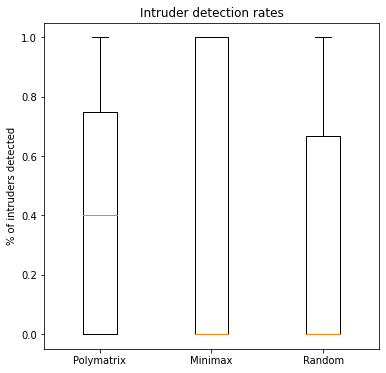

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_boxplots([poly_int_det_rates, minimax_int_det_rates, rand_int_det_rates],
              ax, box_labels=['Polymatrix', 'Minimax', 'Random'],
              title='Intruder detection rates',
              ylabel='% of intruders detected',
              showfliers=False)
fig.savefig('visualizations/int-det-rates-gqq.png', bbox_inches='tight')

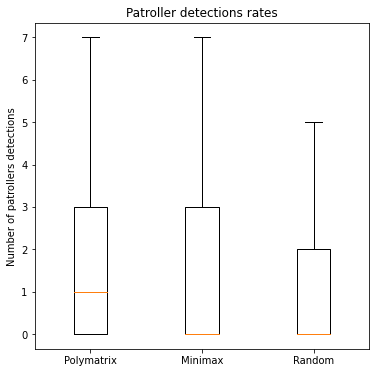

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_boxplots([poly_pat_det_rates, minimax_pat_det_rates, rand_pat_det_rates],
              ax, box_labels=['Polymatrix', 'Minimax', 'Random'],
              title='Patroller detections rates',
              ylabel='Number of patrollers detections',
              showfliers=False)
fig.savefig('visualizations/pat-det-rates-gqq.png', bbox_inches='tight')

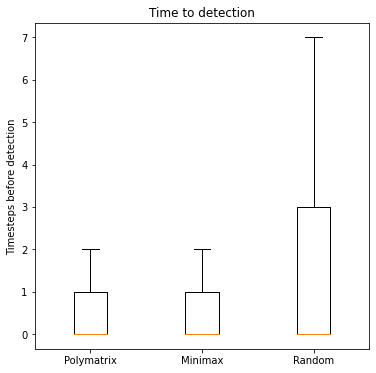

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
draw_boxplots([poly_det_times, minimax_det_times, rand_det_times],
              ax, box_labels=['Polymatrix', 'Minimax', 'Random'],
              title='Time to detection',
              ylabel='Timesteps before detection',
              showfliers=False)
fig.savefig('visualizations/det-time-gqq.png', bbox_inches='tight')